In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from alpha_vantage.timeseries import TimeSeries
import os

In [2]:
TIME_SERIES = TimeSeries(key=os.environ.get("ALPHA_VANTAGE_KEY"), output_format="pandas", indexing_type="data")
COLUMN_RENAME_DAILY = {"date": "Date", "1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. adjusted close": "Adj Close", "6. volume": "Volume"}
COLUMN_RENAME_INTRA_DAY = {"date": "Date", "1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. volume": "Volume"}

In [3]:
## STARTED SONN NOT REALLY BUT FOR SELLING PURPOSES: DATE: 2021-08-20 00:00:00 day 60: buy 1000 units at price 631.300000, total balance 231.270000
## STARTED FAMI NOT REALLY BUT FOR SELLING PURPOSES: DATE: 2021-08-27 00:00:00 day 24: buy 1000 units at price 391.300000, total balance 608.700000
TICKER = "CEI"
TICKER

'CEI'

In [4]:
dailyAdjustedRaw = TIME_SERIES.get_daily_adjusted(symbol=TICKER, outputsize="full")[0]
df = dailyAdjustedRaw.sort_values(by="date", ascending=False).reset_index().rename(columns=COLUMN_RENAME_DAILY).drop(["7. dividend amount", "8. split coefficient"], axis=1, inplace=False)
# dailyAdjustedRaw = TIME_SERIES.get_intraday(symbol=TICKER, outputsize="full", interval="60min")[0]
# df = dailyAdjustedRaw.sort_values(by="date", ascending=False).reset_index().rename(columns=COLUMN_RENAME_INTRA_DAY)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-04,3.31,3.65,3.05,3.09,3.09,212600954.0
1,2021-10-01,3.49,3.54,2.86,3.25,3.25,323930920.0
2,2021-09-30,4.13,4.37,3.44,3.82,3.82,460059396.0
3,2021-09-29,3.06,4.85,2.89,3.42,3.42,988353227.0
4,2021-09-28,2.88,3.44,2.62,3.22,3.22,761080418.0


In [5]:
df = df.head(90).sort_values(by="Date", ascending=True).reset_index().drop(["index"], axis=1, inplace=False)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-27,0.6150,0.6967,0.6060,0.6600,0.6600,14771883.0
1,2021-05-28,0.6648,0.6700,0.6253,0.6398,0.6398,5274171.0
2,2021-06-01,0.6549,0.7198,0.6525,0.6892,0.6892,13767097.0
3,2021-06-02,0.6910,0.7050,0.6600,0.6697,0.6697,6172544.0
4,2021-06-03,0.6800,0.6880,0.6500,0.6642,0.6642,5279271.0


In [6]:
# df = pd.read_csv('../dataset/GOOG-year.csv')
# df.tail()

In [7]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,0.6600,NaN,NaN
1,0.0,0.6398,NaN,NaN
2,0.0,0.6892,NaN,NaN
3,0.0,0.6697,NaN,NaN
4,0.0,0.6642,NaN,NaN
...,...,...,...,...
85,-1.0,3.2200,2.72,1.46
86,-1.0,3.4200,3.22,1.46
87,-1.0,3.8200,3.42,1.46
88,0.0,3.2500,3.82,1.46


In [8]:
def buy_stock(
    real_movement,
    signal,
    dates,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'DATE: %s day %d: total balances %f, not enough money to buy a unit price %f'
                % (dates[i], i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'DATE: %s day %d: buy %d units at price %f, total balance %f'
                % (dates[i], i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('DATE: %s day %d: cannot sell anything, inventory 0' % (dates[i], i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'DATE: %s day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (dates[i], i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [9]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'], df.Date, initial_money=1000, max_buy=1000, max_sell=1000)

DATE: 2021-06-16 00:00:00 day 13: cannot sell anything, inventory 0
DATE: 2021-06-18 00:00:00 day 15: buy 1000 units at price 643.300000, total balance 356.700000
DATE: 2021-06-29 00:00:00 day 22: buy 566 units at price 356.580000, total balance 0.120000
DATE: 2021-07-01 00:00:00 day 24, sell 1000 units at price 767.600000, investment 21.841270 %, total balance 767.720000,
DATE: 2021-07-06 00:00:00 day 26: buy 1000 units at price 628.100000, total balance 139.620000
DATE: 2021-07-07 00:00:00 day 27: buy 240 units at price 139.200000, total balance 0.420000
DATE: 2021-07-08 00:00:00 day 28: total balances 0.420000, not enough money to buy a unit price 0.552100
DATE: 2021-07-13 00:00:00 day 31: total balances 0.420000, not enough money to buy a unit price 0.548600
DATE: 2021-07-15 00:00:00 day 33: total balances 0.420000, not enough money to buy a unit price 0.533000
DATE: 2021-07-16 00:00:00 day 34: total balances 0.420000, not enough money to buy a unit price 0.503000
DATE: 2021-07-19 

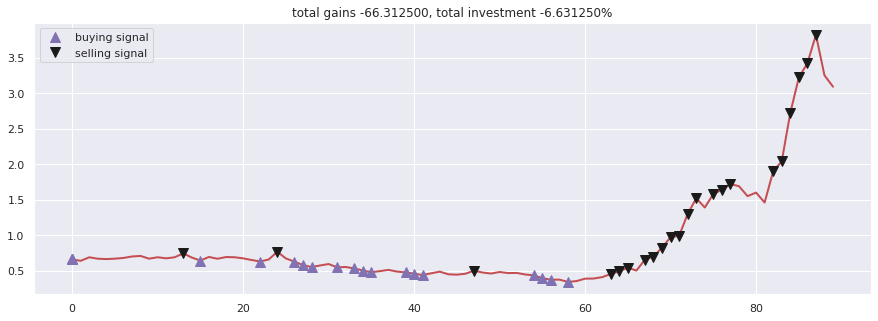

In [10]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()